**Uwaga**: Zadania należy wykonać  w notatniku Jupyter.

1. Zapoznaj się z teorią algorytmu klastrowania K-means (klasyczny alogorytm w dziedzinie eksploracji danych (ang. <a href="https://en.wikipedia.org/wiki/Data_mining">data mining))</a>) np. przez stronę <a href="https://www.statystyka.eu/analiza-skupien/metoda-k-srednich.php">metoda-k-średnich</a>. Przestestuj jedną wybraną metrykę, inną  niż euklidesowa - wykonaj obrazy pokazujące efekty jej działania.
   
2. Przeczytaj, przeanalizuj i przetestuj materiał na stronie  <a href="https://www.kaggle.com/code/jaidevchittoria/k-means-from-scratch-iris">k-means-from-scratch-iris</a> (**Irysy** stanowią kanoniczny zbiór danych w w różnych zadaniach eksploracji danych i uczenia maszynowego )

   - Powtórz doświadczenie zmieniając metrykę euklidesową na metrykę $L_1$ 
   - Powtórz doświadczenie z metryką euklidesową usuwając z danych jedną klasę.
<p></p>

3. Wykonaj ponownie powyższe doświadczenie, tym razem skupiając się na sposobach wizualizacji danych i wyników. Posłuż
   się materiałem na stronie
   
   https://www.kaggle.com/code/khotijahs1/k-means-clustering-of-iris-dataset
   
    - Przeczytaj dokumentacje wszystkich nowych dla siebie funkcji.
    - W szczególności przeczytaj uwagi o mierzeniu odległości  w użytej tu implementacji algorytmu K-means - punkt 2.3.2 na stronie <a href="https://scikit-learn.org/stable/modules/clustering.html">scikit-learn.org/stable/modules/clustering</a> .
        
Dane pobierz  z adresu <a href="https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/0e7a9b0a5d22642a06d3d5b9bcbad9890c8ee534/iris.csv">iris.csv</a>

## Zadanie 1

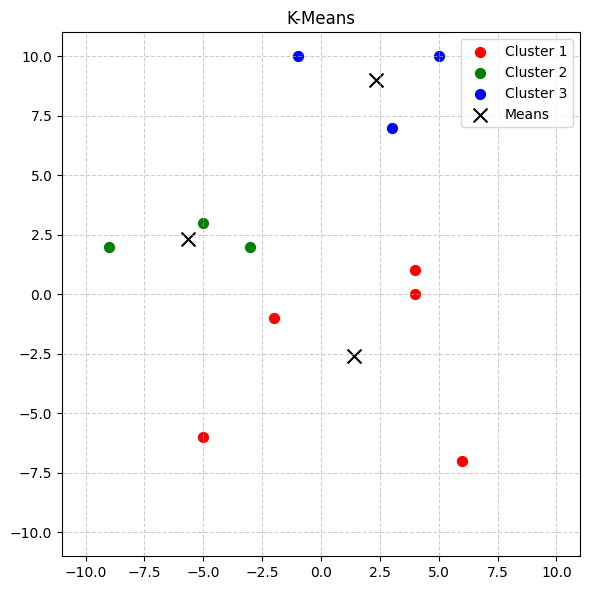

In [58]:
import matplotlib.pyplot as plt
import numpy as np

def norm(a, b): 
  return np.max(np.abs(a - b))  # Norma czebyszewa

def kmeans(points, means_amount=3, iterations=5):
  # Create random means
  min_vals = points.min(axis=0)
  max_vals = points.max(axis=0)
  means = [[-2, -1], [-5, 3], [4, 1]]
  # means = np.random.uniform(min_vals, max_vals, (means_amount, 2))
  
  # Iterate
  for _ in range(iterations):
    # Set points to means
    labels = []
    for p in points:
      distances = [norm(p, m) for m in means]
      labels.append(np.argmin(distances))
    labels = np.array(labels)
    
    # New means
    new_means = []
    for i in range(means_amount):
      cluster_points = points[labels == i]
      if len(cluster_points) > 0:
        new_means.append(cluster_points.mean(axis=0))
      else:
        new_means.append(np.random.uniform(min_vals, max_vals))
    new_means = np.array(new_means)
    
    # check if are close
    if np.allclose(means, new_means):
        break
    means = new_means
  
  return labels, means




points = np.array([
    [-1, 10], [3, 7], [-3, 2], [-2, -1], [4, 0],
    [6, -7], [-5, -6], [-9, 2], [-5, 3], [4, 1], [5, 10]
])

labels, means = kmeans(points, means_amount=3, iterations=10)
colors = ['red', 'green', 'blue']


# print on plot
plt.figure(figsize=(6, 6))

# add points with colors
for i in range(len(means)):
    cluster = points[labels == i]
    plt.scatter(cluster[:, 0], cluster[:, 1], color=colors[i % len(colors)], s=50, label=f'Cluster {i+1}')

# add means
plt.scatter(means[:, 0], means[:, 1], color='black', marker='x', s=100, label='Means')

plt.xlim(-11, 11)
plt.ylim(-11, 11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.title('K-Means')
plt.legend()
plt.tight_layout()
plt.show()


## Zadanie 2

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from collections import defaultdict
from sklearn import datasets
from sklearn.cluster import KMeans as SKLearnKMeans

warnings.simplefilter("ignore")
np.random.seed(42)

# Load the dataset
iris = datasets.load_iris()
X = pd.DataFrame(iris.data, columns=['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width'])
y = pd.DataFrame(iris.target, columns=['Classes'])

# Add species names
X['species'] = pd.Series(np.random.randn(150), index=X.index)
X['species'][y['Classes'] == 0] = 'Setosa'
X['species'][y['Classes'] == 1] = 'versicolor'
X['species'][y['Classes'] == 2] = 'virginica'

clusters = len(np.unique(y))

# Euclidean distance function
def euclidean_dis(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

# L1 distance function
def l1_dis(x1, x2): 
    return np.max(np.abs(x1 - x2))

In [60]:
# -------------------------
# K-Means implementation
# -------------------------
class KMeans:
    def __init__(self, data, k, max_ite, l1_norm = False):
        self.data = data
        self.k = k
        self.max_ite = max_ite
        self.l1_norm = l1_norm
        
    def predict(self):
        centroids = defaultdict(int)
        K = self.k
        max_iter = self.max_ite
        
        # Initialize centroids as first K points
        for i in range(K):
            centroids[i] = self.data[i]
        
        for _ in range(max_iter):
            classes = defaultdict(list)
            for key in range(K):
                classes[key] = []
            
            # Assign points to nearest centroid
            for datapoint in self.data:
              distance = 0;
              if(self.l1_norm):
                distance = [l1_dis(datapoint, centroids[j]) for j in range(K)]
              else:
                distance = [euclidean_dis(datapoint, centroids[j]) for j in range(K)]
              index = np.argmin(distance)
              classes[index].append(datapoint)
            
            old_centroid = dict(centroids)
            
            # Recalculate centroids
            for t in range(K):
                centroids[t] = np.mean(classes[t], axis=0)
            
            # Check for convergence
            flg = 1
            for t in range(K):
                a = centroids[t]
                b = old_centroid[t]
                if np.sum((a - b) / b * 100) > 0.001:
                    flg = 0
            if flg == 1:
                break
        return classes, centroids

### L2 Norm

In [61]:

# Run custom KMeans
kmeans = KMeans(iris.data[:, :4], clusters, 10000)
classes, centroids = kmeans.predict()

for i in range(3):
    classes[i] = np.array(classes[i]).tolist()

for i in range(3):
    print(f"Cluster {i} size: {len(classes[i])}")
print("Centroids:\n", centroids)

# -------------------------
# Performance Metrics
# -------------------------
class0, class1, class2 = [], [], []
for i in range(len(iris.target)):
    if iris.target[i] == 0:
        class0.append(iris.data[i])
    elif iris.target[i] == 1:
        class1.append(iris.data[i])
    elif iris.target[i] == 2:
        class2.append(iris.data[i])
class0, class1, class2 = np.array(class0).tolist(), np.array(class1).tolist(), np.array(class2).tolist()

def subset(array1, array2):
    return any(np.allclose(array2, x) for x in array1)

def confusion_matrix(a, b, c, classes):
    cm = [[0 for _ in range(y.Classes.nunique())] for _ in range(y.Classes.nunique())]
    for element in a:
        if subset(classes[2], element): cm[0][0] += 1
        elif subset(classes[1], element): cm[0][1] += 1
        elif subset(classes[0], element): cm[0][2] += 1
    for element in b:
        if subset(classes[2], element): cm[1][0] += 1
        elif subset(classes[1], element): cm[1][1] += 1
        elif subset(classes[0], element): cm[1][2] += 1
    for element in c:
        if subset(classes[2], element): cm[2][0] += 1
        elif subset(classes[1], element): cm[2][1] += 1
        elif subset(classes[0], element): cm[2][2] += 1
    return cm

class Metrics:
    def __init__(self, confusion_m):
        self.confusion_m = np.array(confusion_m)
        self.total = np.sum(confusion_m)
        self.diagonal = np.sum(np.diag(confusion_m))
    
    def accuracy(self):
        return self.diagonal / self.total
    
    def recall(self):
        recall = np.diag(self.confusion_m) / np.sum(self.confusion_m, axis=1)
        return np.mean(recall)
    
    def precision(self):
        precision = np.diag(self.confusion_m) / np.sum(self.confusion_m, axis=0)
        return np.mean(precision)
    
    def f1_score(self, precision, recall):
        return (2 * precision * recall) / (precision + recall)

# Compute metrics
matrix = confusion_matrix(class0, class1, class2, classes)
performance = Metrics(matrix)
accuracy = performance.accuracy()
recall = performance.recall()
precision = performance.precision()
f1_score = performance.f1_score(precision, recall)

print("\nConfusion Matrix:\n", np.array(matrix))
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"F1-Score: {f1_score*100:.2f}%")

# -------------------------
# Comparison with scikit-learn
# -------------------------
sk_kmeans = SKLearnKMeans(n_clusters=3, init='k-means++', random_state=42)
y_k = sk_kmeans.fit_predict(iris.data)
print("\nKMeans (scikit-learn) cluster assignments:\n", y_k)


Cluster 0 size: 39
Cluster 1 size: 61
Cluster 2 size: 50
Centroids:
 defaultdict(<class 'int'>, {0: array([6.85384615, 3.07692308, 5.71538462, 2.05384615]), 1: array([5.88360656, 2.74098361, 4.38852459, 1.43442623]), 2: array([5.006, 3.428, 1.462, 0.246])})

Confusion Matrix:
 [[50  0  0]
 [ 0 47  3]
 [ 0 14 36]]
Accuracy: 88.67%
Recall: 88.67%
Precision: 89.79%
F1-Score: 89.22%

KMeans (scikit-learn) cluster assignments:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 0 0 0 2 0 0 0 0
 0 0 2 2 0 0 0 0 2 0 2 0 2 0 0 2 2 0 0 0 0 0 2 0 0 0 0 2 0 0 0 2 0 0 0 2 0
 0 2]


### L1 Norm

In [62]:

# Run custom KMeans
kmeans = KMeans(iris.data[:, :4], clusters, 10000, True)
classes, centroids = kmeans.predict()

for i in range(3):
    classes[i] = np.array(classes[i]).tolist()

for i in range(3):
    print(f"Cluster {i} size: {len(classes[i])}")
print("Centroids:\n", centroids)

# -------------------------
# Performance Metrics
# -------------------------
class0, class1, class2 = [], [], []
for i in range(len(iris.target)):
    if iris.target[i] == 0:
        class0.append(iris.data[i])
    elif iris.target[i] == 1:
        class1.append(iris.data[i])
    elif iris.target[i] == 2:
        class2.append(iris.data[i])
class0, class1, class2 = np.array(class0).tolist(), np.array(class1).tolist(), np.array(class2).tolist()

def subset(array1, array2):
    return any(np.allclose(array2, x) for x in array1)

def confusion_matrix(a, b, c, classes):
    cm = [[0 for _ in range(y.Classes.nunique())] for _ in range(y.Classes.nunique())]
    for element in a:
        if subset(classes[2], element): cm[0][0] += 1
        elif subset(classes[1], element): cm[0][1] += 1
        elif subset(classes[0], element): cm[0][2] += 1
    for element in b:
        if subset(classes[2], element): cm[1][0] += 1
        elif subset(classes[1], element): cm[1][1] += 1
        elif subset(classes[0], element): cm[1][2] += 1
    for element in c:
        if subset(classes[2], element): cm[2][0] += 1
        elif subset(classes[1], element): cm[2][1] += 1
        elif subset(classes[0], element): cm[2][2] += 1
    return cm

class Metrics:
    def __init__(self, confusion_m):
        self.confusion_m = np.array(confusion_m)
        self.total = np.sum(confusion_m)
        self.diagonal = np.sum(np.diag(confusion_m))
    
    def accuracy(self):
        return self.diagonal / self.total
    
    def recall(self):
        recall = np.diag(self.confusion_m) / np.sum(self.confusion_m, axis=1)
        return np.mean(recall)
    
    def precision(self):
        precision = np.diag(self.confusion_m) / np.sum(self.confusion_m, axis=0)
        return np.mean(precision)
    
    def f1_score(self, precision, recall):
        return (2 * precision * recall) / (precision + recall)

# Compute metrics
matrix = confusion_matrix(class0, class1, class2, classes)
performance = Metrics(matrix)
accuracy = performance.accuracy()
recall = performance.recall()
precision = performance.precision()
f1_score = performance.f1_score(precision, recall)

print("\nConfusion Matrix:\n", np.array(matrix))
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"F1-Score: {f1_score*100:.2f}%")

# -------------------------
# Comparison with scikit-learn
# -------------------------
sk_kmeans = SKLearnKMeans(n_clusters=3, init='k-means++', random_state=42)
y_k = sk_kmeans.fit_predict(iris.data)
print("\nKMeans (scikit-learn) cluster assignments:\n", y_k)


Cluster 0 size: 99
Cluster 1 size: 24
Cluster 2 size: 27
Centroids:
 defaultdict(<class 'int'>, {0: array([6.27373737, 2.87575758, 4.92525253, 1.68181818]), 1: array([5.09583333, 3.27083333, 1.57083333, 0.2875    ]), 2: array([4.92962963, 3.53333333, 1.42222222, 0.24074074])})

Confusion Matrix:
 [[27 23  0]
 [ 0  1 49]
 [ 0  0 50]]
Accuracy: 52.00%
Recall: 52.00%
Precision: 51.56%
F1-Score: 51.78%

KMeans (scikit-learn) cluster assignments:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 0 0 0 2 0 0 0 0
 0 0 2 2 0 0 0 0 2 0 2 0 2 0 0 2 2 0 0 0 0 0 2 0 0 0 0 2 0 0 0 2 0 0 0 2 0
 0 2]


### 2 classes

In [63]:

# Run custom KMeans
kmeans = KMeans(iris.data[:, :4], clusters, 10000)
classes, centroids = kmeans.predict()

for i in range(2):
    classes[i] = np.array(classes[i]).tolist()

for i in range(2):
    print(f"Cluster {i} size: {len(classes[i])}")
print("Centroids:\n", centroids)

# -------------------------
# Performance Metrics
# -------------------------
class0, class1 = [], []
for i in range(len(iris.target)):
    if iris.target[i] == 0:
        class0.append(iris.data[i])
    elif iris.target[i] == 1:
        class1.append(iris.data[i])

class0, class1 = np.array(class0).tolist(), np.array(class1).tolist()

def subset(array1, array2):
    return any(np.allclose(array2, x) for x in array1)

def confusion_matrix(a, b, classes):
    cm = [[0 for _ in range(y.Classes.nunique())] for _ in range(y.Classes.nunique())]
    for element in a:
        if subset(classes[2], element): cm[0][0] += 1
        elif subset(classes[1], element): cm[0][1] += 1
        elif subset(classes[0], element): cm[0][2] += 1
    for element in b:
        if subset(classes[2], element): cm[1][0] += 1
        elif subset(classes[1], element): cm[1][1] += 1
        elif subset(classes[0], element): cm[1][2] += 1
    return cm

class Metrics:
    def __init__(self, confusion_m):
        self.confusion_m = np.array(confusion_m)
        self.total = np.sum(confusion_m)
        self.diagonal = np.sum(np.diag(confusion_m))
    
    def accuracy(self):
        return self.diagonal / self.total
    
    def recall(self):
        recall = np.diag(self.confusion_m) / np.sum(self.confusion_m, axis=1)
        return np.mean(recall)
    
    def precision(self):
        precision = np.diag(self.confusion_m) / np.sum(self.confusion_m, axis=0)
        return np.mean(precision)
    
    def f1_score(self, precision, recall):
        return (2 * precision * recall) / (precision + recall)

# Compute metrics
matrix = confusion_matrix(class0, class1, classes)
performance = Metrics(matrix)
accuracy = performance.accuracy()
recall = performance.recall()
precision = performance.precision()
f1_score = performance.f1_score(precision, recall)

print("\nConfusion Matrix:\n", np.array(matrix))
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"F1-Score: {f1_score*100:.2f}%")

# -------------------------
# Comparison with scikit-learn
# -------------------------
sk_kmeans = SKLearnKMeans(n_clusters=3, init='k-means++', random_state=42)
y_k = sk_kmeans.fit_predict(iris.data)
print("\nKMeans (scikit-learn) cluster assignments:\n", y_k)


Cluster 0 size: 39
Cluster 1 size: 61
Centroids:
 defaultdict(<class 'int'>, {0: array([6.85384615, 3.07692308, 5.71538462, 2.05384615]), 1: array([5.88360656, 2.74098361, 4.38852459, 1.43442623]), 2: array([5.006, 3.428, 1.462, 0.246])})

Confusion Matrix:
 [[50  0  0]
 [ 0 47  3]
 [ 0  0  0]]
Accuracy: 97.00%
Recall: nan%
Precision: 66.67%
F1-Score: nan%

KMeans (scikit-learn) cluster assignments:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 0 0 0 2 0 0 0 0
 0 0 2 2 0 0 0 0 2 0 2 0 2 0 0 2 2 0 0 0 0 0 2 0 0 0 0 2 0 0 0 2 0 0 0 2 0
 0 2]


## Zadanie 3

📄 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None 

🔹 First 10 rows:


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa



📊 Species Frequency Distribution:


col_0,count
species,
setosa,50
versicolor,50
virginica,50


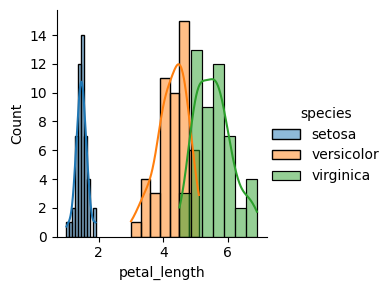

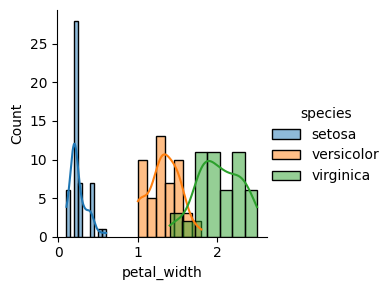

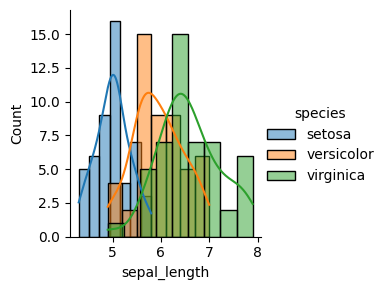

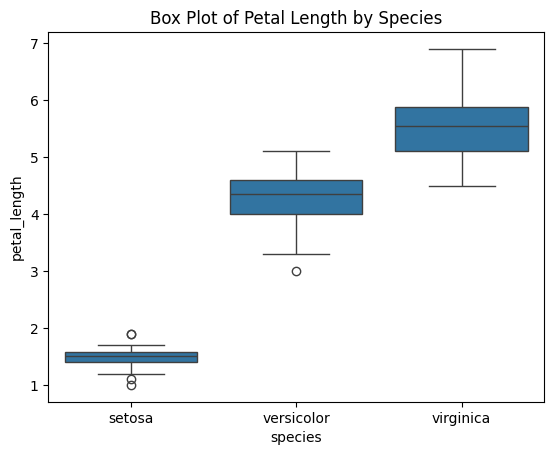

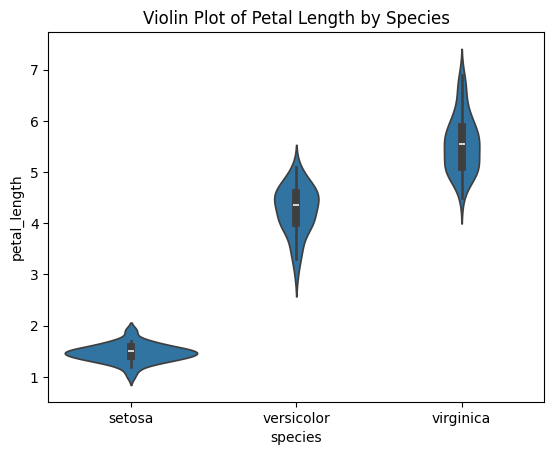

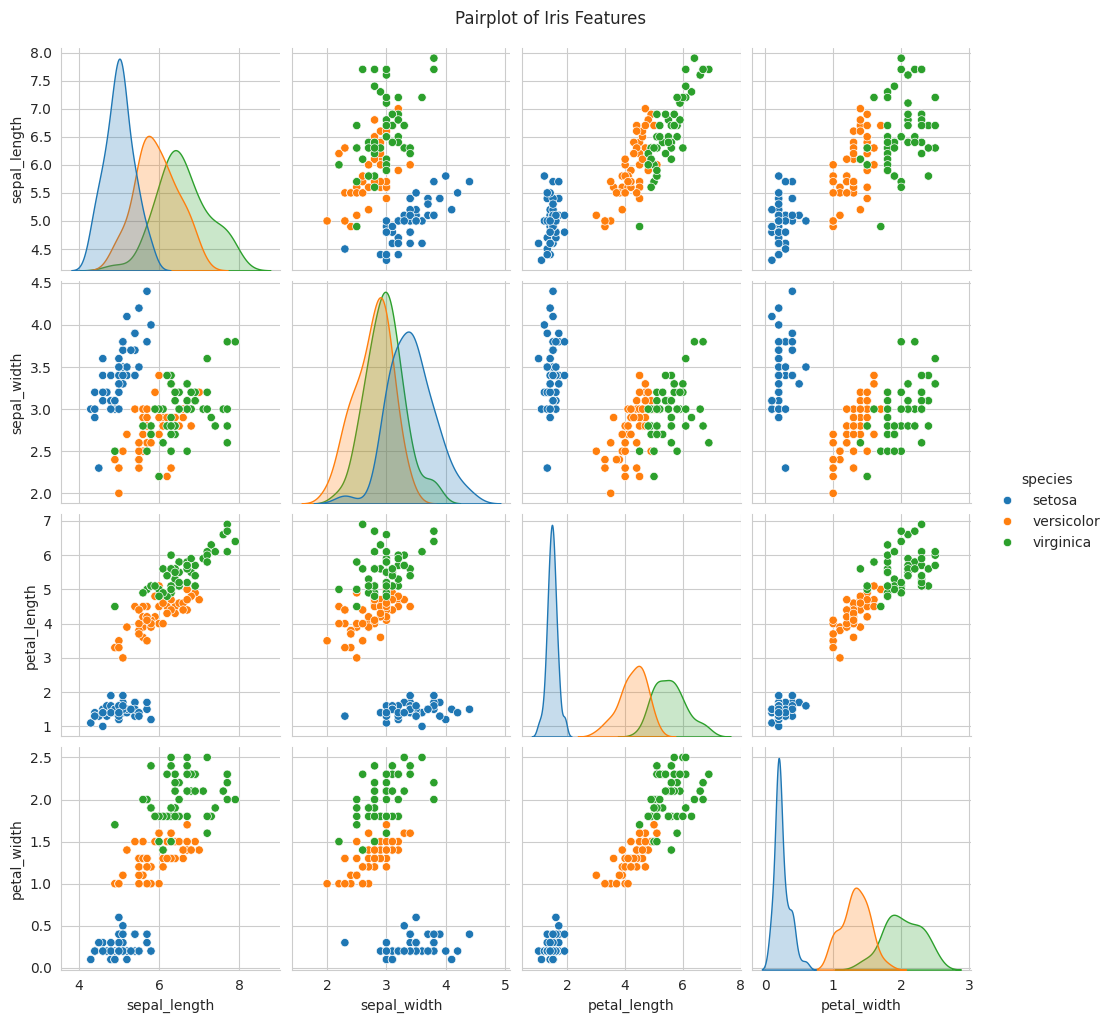

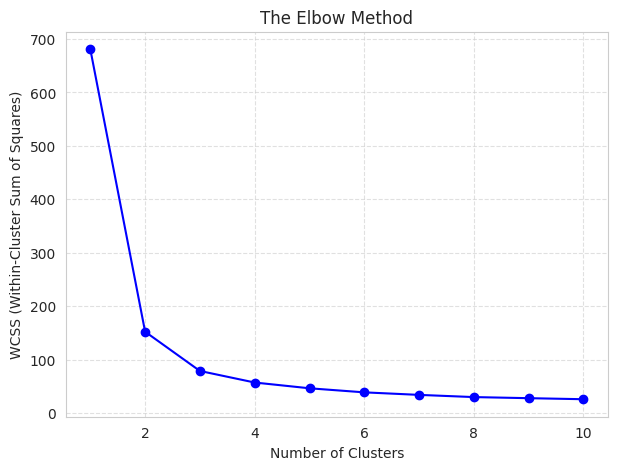

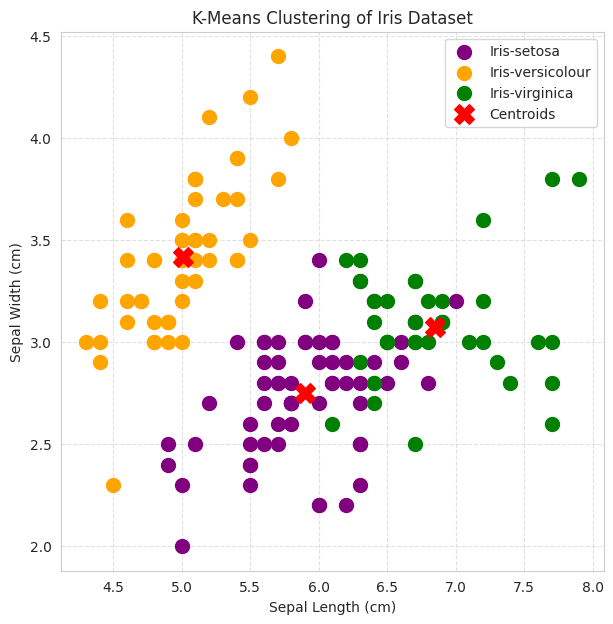

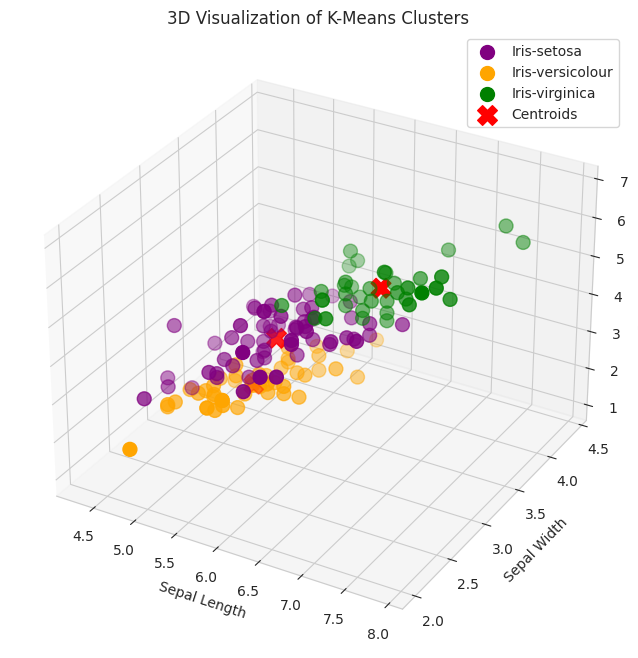

In [65]:
# 🪷 IRIS DATASET — K-MEANS CLUSTERING STUDY
# ------------------------------------------------------
# Complete Jupyter notebook cell
# ------------------------------------------------------

# 1️⃣ Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D

# 2️⃣ Load Dataset
iris = pd.read_csv("iris.csv")

# Separate features
x = iris.iloc[:, [0, 1, 2, 3]].values

# Display dataset info
print("📄 Dataset Info:")
print(iris.info(), "\n")
print("🔹 First 10 rows:")
display(iris.head(10))

# 3️⃣ Frequency distribution of species
iris_outcome = pd.crosstab(index=iris["species"], columns="count")
print("\n📊 Species Frequency Distribution:")
display(iris_outcome)

# 4️⃣ Separate data by species
iris_setosa = iris.loc[iris["species"] == "Iris-setosa"]
iris_virginica = iris.loc[iris["species"] == "Iris-virginica"]
iris_versicolor = iris.loc[iris["species"] == "Iris-versicolor"]

# 5️⃣ Distribution plots
sns.FacetGrid(iris, hue="species", height=3).map(sns.histplot, "petal_length", kde=True).add_legend()
sns.FacetGrid(iris, hue="species", height=3).map(sns.histplot, "petal_width", kde=True).add_legend()
sns.FacetGrid(iris, hue="species", height=3).map(sns.histplot, "sepal_length", kde=True).add_legend()
plt.show()

# 6️⃣ Box plot
sns.boxplot(x="species", y="petal_length", data=iris)
plt.title("Box Plot of Petal Length by Species")
plt.show()

# 7️⃣ Violin plot
sns.violinplot(x="species", y="petal_length", data=iris)
plt.title("Violin Plot of Petal Length by Species")
plt.show()

# 8️⃣ Pairplot (Scatter Matrix)
sns.set_style("whitegrid")
sns.pairplot(iris, hue="species", height=2.5)
plt.suptitle("Pairplot of Iris Features", y=1.02)
plt.show()

# 9️⃣ Finding optimum number of clusters — Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(
        n_clusters=i, init='k-means++', 
        max_iter=300, n_init=10, random_state=0
    )
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(7,5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='blue')
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 🔟 Implementing K-Means Clustering (k=3)
kmeans = KMeans(
    n_clusters=3, init='k-means++',
    max_iter=300, n_init=10, random_state=0
)
y_kmeans = kmeans.fit_predict(x)

# 11️⃣ Visualising Clusters (2D)
plt.figure(figsize=(7,7))
plt.scatter(x[y_kmeans == 0, 0], x[y_kmeans == 0, 1], s=100, c='purple', label='Iris-setosa')
plt.scatter(x[y_kmeans == 1, 0], x[y_kmeans == 1, 1], s=100, c='orange', label='Iris-versicolour')
plt.scatter(x[y_kmeans == 2, 0], x[y_kmeans == 2, 1], s=100, c='green', label='Iris-virginica')

# Plotting centroids
plt.scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    s=200, c='red', marker='X', label='Centroids'
)
plt.title("K-Means Clustering of Iris Dataset")
plt.xlabel("Sepal Length (cm)")
plt.ylabel("Sepal Width (cm)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 12️⃣ 3D Scatter Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    x[y_kmeans == 0, 0], x[y_kmeans == 0, 1], x[y_kmeans == 0, 2],
    s=100, c='purple', label='Iris-setosa'
)
ax.scatter(
    x[y_kmeans == 1, 0], x[y_kmeans == 1, 1], x[y_kmeans == 1, 2],
    s=100, c='orange', label='Iris-versicolour'
)
ax.scatter(
    x[y_kmeans == 2, 0], x[y_kmeans == 2, 1], x[y_kmeans == 2, 2],
    s=100, c='green', label='Iris-virginica'
)
ax.scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    kmeans.cluster_centers_[:, 2],
    s=200, c='red', marker='X', label='Centroids'
)
ax.set_title("3D Visualization of K-Means Clusters")
ax.set_xlabel("Sepal Length")
ax.set_ylabel("Sepal Width")
ax.set_zlabel("Petal Length")
ax.legend()
plt.show()
